# K-Means Clustering Analysis

This notebook implements the clustering component of the project.
We load the feature matrix, preprocess it, run K-Means with several values of *k*,
evaluate the clustering using different metrics, select the best configuration,
and visualize the resulting clusters using PCA.


In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import os
from google.colab import drive

import warnings
warnings.filterwarnings('ignore')


In [3]:
drive.mount('/content/drive')
ZIP_PATH = "/content/drive/MyDrive/patternmind_dataset.zip"
UNZIP_DIR = "/content/patternmind_unzipped"

!mkdir -p "{UNZIP_DIR}"
!unzip -q "{ZIP_PATH}" -d "{UNZIP_DIR}"

Mounted at /content/drive


In [4]:
DATASET_DIR_NAME = "patternmind_dataset"   # the folder inside the zip

DATA_ROOT = os.path.join(UNZIP_DIR, DATASET_DIR_NAME)
print("Will use DATA_ROOT:", DATA_ROOT)


if not os.path.isdir(DATA_ROOT):
    os.makedirs(UNZIP_DIR, exist_ok=True)
    !unzip -q "{ZIP_PATH}" -d "{UNZIP_DIR}"
    print("Unzipped dataset.")
else:
    print("Dataset already unzipped.")

Will use DATA_ROOT: /content/patternmind_unzipped/patternmind_dataset
Dataset already unzipped.


In [6]:
%cd "/content/drive/MyDrive/projectml colab"

import os
print("CWD:", os.getcwd())
print("Files here:", os.listdir())


/content/drive/MyDrive/projectml colab
CWD: /content/drive/MyDrive/projectml colab
Files here: ['X_features.npy', 'label_names.npy', 'y_labels.npy']


## 1. Load & Preprocess Data

We load the `.npy` feature matrix, standardize all features using `StandardScaler`,
and keep the full dataset for clustering. Standardization is important because
K-Means is distance-based and is sensitive to the scale of the features.


In [7]:
# Load the feature matrix (ensure X_features.npy is in the same folder as this notebook)
X = np.load('X_features.npy')
print('Original shape:', X.shape)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print('Scaled shape:', X_scaled.shape)


Original shape: (25557, 2048)
Scaled shape: (25557, 2048)


In [8]:
print("Mean of first 5 features:", X_scaled[:, :5].mean(axis=0))
print("Std of first 5 features:", X_scaled[:, :5].std(axis=0))


Mean of first 5 features: [ 3.21914513e-07 -1.04078985e-07  1.19976590e-07  2.56369481e-06
 -2.14430486e-07]
Std of first 5 features: [1.0000151  0.9999939  0.9999947  0.9999766  0.99999994]


In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components=50, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print("PCA-reduced shape:", X_pca.shape)


PCA-reduced shape: (25557, 50)


## 2. K-Means Experiments

We test K-Means with different numbers of clusters:
`k = 10, 20, 30, 40, 50`.

For each configuration we compute three clustering quality metrics:
- **Silhouette Score** (higher is better)
- **Calinski–Harabasz Index** (higher is better)
- **Davies–Bouldin Index** (lower is better)


In [14]:
k_values = [10, 20, 30, 40, 50]
results = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)

    sil = silhouette_score(X_scaled, labels)
    ch = calinski_harabasz_score(X_scaled, labels)
    db = davies_bouldin_score(X_scaled, labels)

    results.append([k, sil, ch, db])
    print(f'k={k} | Silhouette={sil:.4f} | CH={ch:.2f} | DB={db:.4f}')

results_df_before_pca = pd.DataFrame(results, columns=['k', 'silhouette', 'calinski_harabasz', 'davies_bouldin'])
results_df_before_pca


k=10 | Silhouette=-0.0299 | CH=309.86 | DB=4.5041
k=20 | Silhouette=-0.0103 | CH=217.27 | DB=4.2817


KeyboardInterrupt: 

When K-Means was applied directly to the full 2048-dimensional ResNet feature vectors, the clustering performance was extremely poor.

The Silhouette scores were negative for all values of k, the Calinski-Harabasz scores were very low, and the Davies-Bouldin values were high (indicating poorly separated clusters).

This behavior is expected due to the curse of dimensionality. In very high-dimensional spaces: distances between points become increasingly similar, K-Means loses its ability to separate groups, noise dominates over meaningful structure, euclidean distance becomes ineffective as a similarity measure.

As a result, the model cannot identify compact, well-separated clusters, even though the underlying dataset contains 233 meaningful classes.

The poor metrics **confirm that K-Means does not perform well on raw high-dimensional deep features**, and dimensionality reduction is required before meaningful clustering can occur.

In [12]:
k_values = [10, 20, 30, 40, 50]
results = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_pca)

    sil = silhouette_score(X_pca, labels)
    ch = calinski_harabasz_score(X_pca, labels)
    db = davies_bouldin_score(X_pca, labels)

    results.append([k, sil, ch, db])
    print(f'k={k} | Silhouette={sil:.4f} | CH={ch:.2f} | DB={db:.4f}')

results_df = pd.DataFrame(results, columns=['k', 'silhouette', 'calinski_harabasz', 'davies_bouldin'])
results_df

k=10 | Silhouette=0.0607 | CH=797.06 | DB=2.8270
k=20 | Silhouette=0.0800 | CH=586.19 | DB=2.6637
k=30 | Silhouette=0.0911 | CH=482.13 | DB=2.5437
k=40 | Silhouette=0.0888 | CH=406.90 | DB=2.5180
k=50 | Silhouette=0.0858 | CH=355.29 | DB=2.5715


,k,silhouette,calinski_harabasz,davies_bouldin
0,10,0.060705,797.057800,2.826958
1,20,0.079993,586.188660,2.663722
2,30,0.091118,482.129639,2.543749
3,40,0.088771,406.902252,2.518027
4,50,0.085809,355.288177,2.571473


After reducing the 2048-dimensional features to 50 principal components, clustering improved dramatically: silhouette scores became positive, CH index increased 3x-4x, DB index decreased noticeably, trends became smooth and interpretable across values of k.

PCA removes noise, compresses the information into fewer dimensions, and creates a space where Euclidean distance is meaningful again.
Therefore, PCA is essential for effective clustering in this project.

## 3. Compare Clustering Metrics

We now visualize how each metric behaves as a function of the number of clusters.
This helps to see trends and to justify the chosen value of *k*.


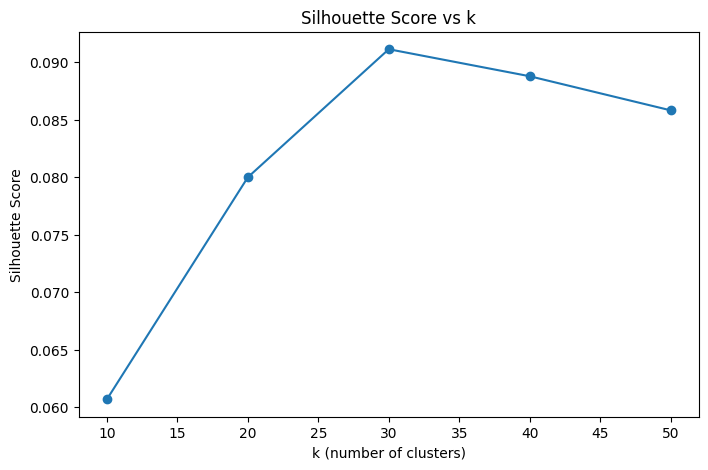

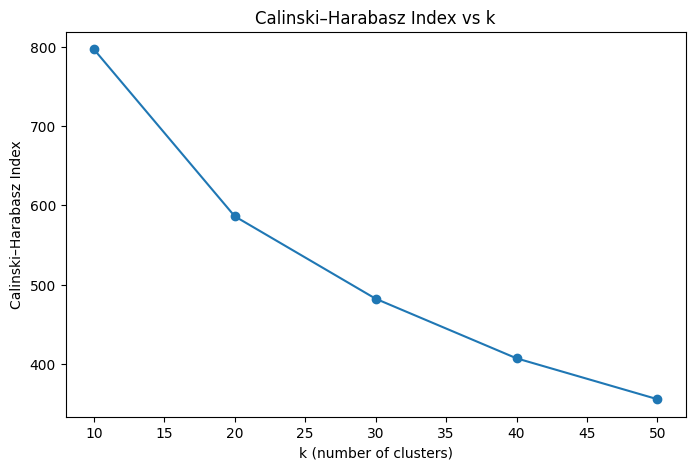

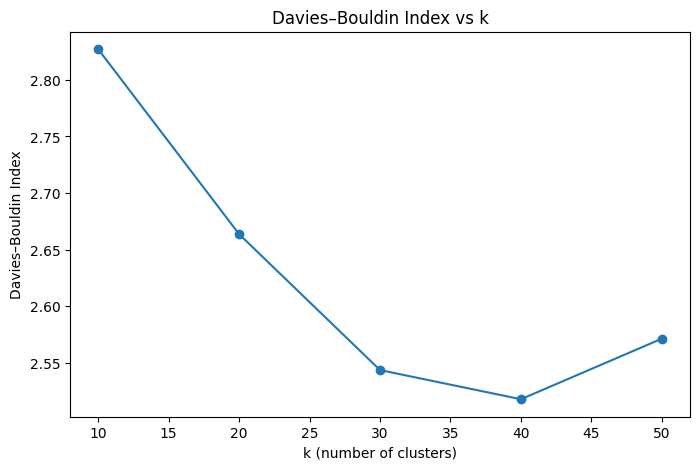

In [13]:
plt.figure(figsize=(8, 5))
plt.plot(results_df['k'], results_df['silhouette'], marker='o')
plt.xlabel('k (number of clusters)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs k')
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(results_df['k'], results_df['calinski_harabasz'], marker='o')
plt.xlabel('k (number of clusters)')
plt.ylabel('Calinski–Harabasz Index')
plt.title('Calinski–Harabasz Index vs k')
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(results_df['k'], results_df['davies_bouldin'], marker='o')
plt.xlabel('k (number of clusters)')
plt.ylabel('Davies–Bouldin Index')
plt.title('Davies–Bouldin Index vs k')
plt.show()


1. Silhouette Score — Best at k = 30

The Silhouette plot shows:
k=10: lowest (≈ 0.060)
k=20: clear improvement (≈ 0.080)
k=30: highest score (≈ 0.091)
k=40 and k=50: slightly decreasing but still high

Silhouette score measures how well-separated the clusters are.
After PCA, all scores are positive, which means K-Means is now finding meaningful structure. The fact that the maximum occurs at k = 30 strongly suggests that 30 clusters provide the best balance between cluster compactness and separation between different clusters

2. Calinski-Harabasz Index — prefers smaller k

Here the trend is strictly decreasing:highest CH score at k = 10 and lower with each increase in k

Why does this happen?
The CH index often decreases as the number of clusters increases because:
clusters get smaller within-cluster variance increases the ratio between “between-cluster” and “within-cluster” variance gets worse.

This does not mean k=10 is objectively better — it only tells us that **small numbers of clusters make the dataset look more globally separated.**

3. Davies-Bouldin Index — best around k = 40

Lower DB means clusters are more compact and more distinct from one another.
DB index decreases until:

Best DB at k = 40 (≈ 2.52)

Slightly worse at k = 30 (≈ 2.54)

Increases again at k = 50


## 4. Select Best k

We select the best number of clusters using the **Silhouette Score** as the
primary criterion (higher is better). The other two metrics are used as
secondary checks.


In [15]:
best_row = results_df.iloc[results_df['silhouette'].idxmax()]
best_k = int(best_row['k'])
print('Best k (by silhouette):', best_k)
best_row


Best k (by silhouette): 30


,2
k,30.000000
silhouette,0.091118
calinski_harabasz,482.129639
davies_bouldin,2.543749


## 5. Run Final K-Means Model and Save Labels

We now fit K-Means again using the selected number of clusters `best_k`.
We store the labels in a separate `.npy` file so they can be reused by
other parts of the project.


In [22]:
best_kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
best_labels = best_kmeans.fit_predict(X_pca)

np.save('best_kmeans_labels.npy', best_labels)
print('Saved labels to best_kmeans_labels.npy')


Saved labels to best_kmeans_labels.npy


In [26]:
!ls "/content/drive/MyDrive/projectml colab"


best_kmeans_labels.npy	images	label_names.npy  X_features.npy  y_labels.npy


## 6. PCA Visualization of Clusters

We reduce the standardized data to 2 dimensions using PCA and plot the
samples colored by their cluster assignment. This gives an intuitive view of
how the clusters are separated in a low-dimensional space.
Due to the high number of samples (25 557), the plot appears dense, qhich is expected. However, color groupings and shape patterns still provide a useful qualitative understanding of the cluster distribution.

Figures are saved in the `images/` folder for inclusion in the report.


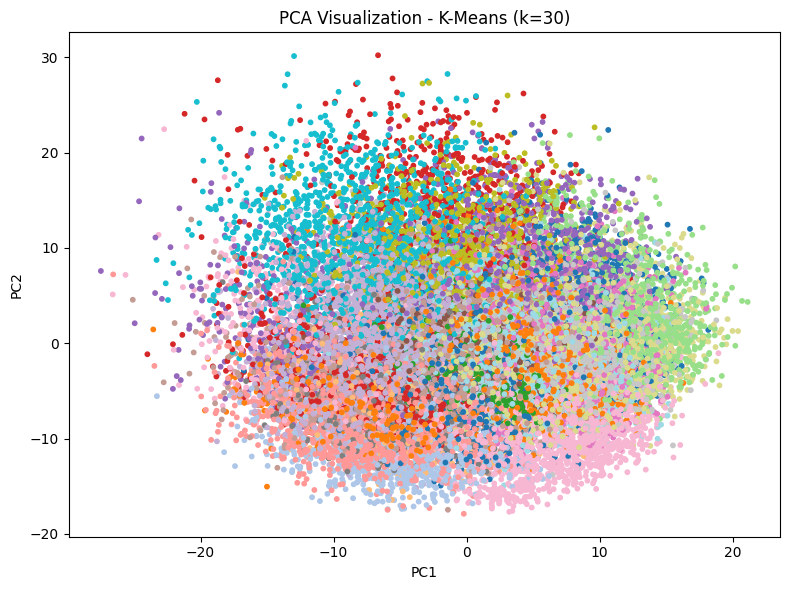

In [20]:
# Ensure images folder exists
os.makedirs('images', exist_ok=True)

pca2 = PCA(n_components=2)
X_pca2 = pca2.fit_transform(X_pca)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca2[:, 0], X_pca2[:, 1], c=best_labels, s=10, cmap='tab20')
plt.title(f'PCA Visualization - K-Means (k={best_k})')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
plt.savefig('images/pca_clusters.png', dpi=300)
plt.show()


## 7. Cluster Size Histogram

We also look at the distribution of samples across clusters. This helps us
understand whether some clusters are very small (potentially noise) or if the
clusters are relatively balanced.

This figure is also saved to the `images/` folder.


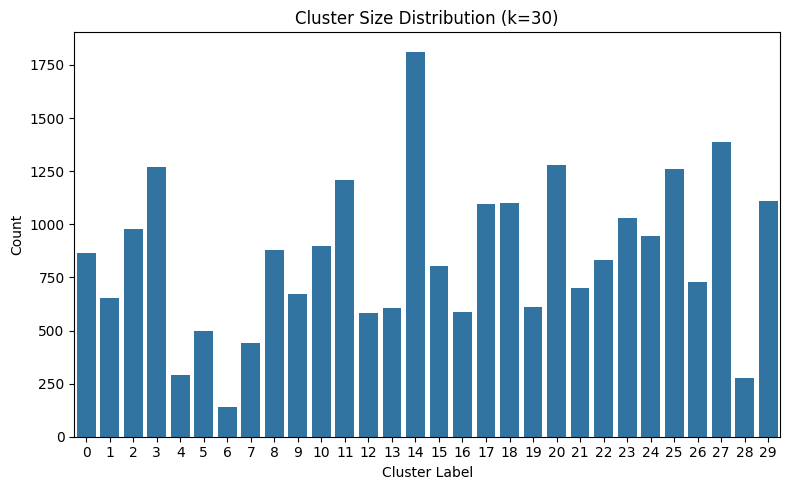

In [18]:
plt.figure(figsize=(8, 5))
sns.countplot(x=best_labels)
plt.title(f'Cluster Size Distribution (k={best_k})')
plt.xlabel('Cluster Label')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('images/cluster_histogram.png', dpi=300)
plt.show()
